## Tutorial for loading OCTRON prediction results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os , sys
from pathlib import Path
cur_path = Path(os.getcwd()).parent.parent
sys.path.append(cur_path.as_posix())
from matplotlib import pyplot as plt
import cmasher as cmr
from tqdm import tqdm
import seaborn as sns # Seaborn is not strictly necessary, but it makes the plots look nicer (:
sns.set_theme(style='white')
%config InlineBackend.figure_format = 'retina'


### YOLO OCTRON results reader

In [3]:
# To access any prediction results programmatically, you can use the YOLO_results class.
from octron import YOLO_results

In [91]:
# This is the output directory that contains csv tracking files and `predictions.zarr` that contains the masks
results_dir = '/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - finished/octo_paralarvae/test_snippets/single hatchling data/resized1024/predictions/20221203_1PL_1mM_Dop2_snippet1_1024x1024_bytetrack'

### Initiate loader class and load data 

In [92]:
yolo_results = YOLO_results(results_dir, verbose=True)

File: 20221203_1PL_1mM_Dop2_snippet1_1024x1024.mp4
Codec: h264
Resolution: 1024 x 1024
Frame Rate: 30.00 fps
Number of frames: 1802
Duration: 60.07 seconds
Found 2 tracking CSV files in '20221203_1PL_1mM_Dop2_snippet1_1024x1024_bytetrack'
Found tracking zarr in '20221203_1PL_1mM_Dop2_snippet1_1024x1024_bytetrack'
Existing keys in zarr archive: ['1_masks', '2_masks']
Found 2 unique track IDs in zarr and CSVs: {1: 'head', 2: 'mantle'}


In [93]:
# yolo_results contains quite a bit of information now ... 
print(yolo_results.height, yolo_results.width, yolo_results.num_frames)
# The track_id_label is a dictionary that contains the track id as key and the label as value
print(yolo_results.track_id_label)

1024 1024 1802
{1: 'head', 2: 'mantle'}


In [94]:
# To load the tracking results: .get_tracking_data() returns a dictionary with track_id as key 
# Check the parameters of the function! 
# It allows you to interpolate the tracking, and to set a limit of frames for that interpolation, 
# and to set a sigma for the gaussian filter that is applied to the tracking
tracking = yolo_results.get_tracking_data(interpolate=True)
tracking.keys()

Frames are not continuous for track_id 1 in head_track_1.csv... interpolating
Frames are not continuous for track_id 2 in mantle_track_2.csv... interpolating


dict_keys([1, 2])

In [95]:
# For each tracked object (i.e. each track_id) we get another dictionary 
# that contains the keys "label", "data" (this is the position data as dataframe),
# and "features" these are the frame by frame features of the object (like area, eccentricity, etc.)
print(tracking[2].keys())
print(tracking[2]['label'])

dict_keys(['label', 'data', 'features'])
mantle


In [96]:
# These are the tracking data 
tracking[2]['data'].head()

,track_id,frame_idx,pos_y,pos_x
0,2,0,721.516097,374.272636
1,2,1,719.402186,372.102732
2,2,2,716.873550,370.479118
3,2,3,715.538462,369.934732
4,2,4,715.554040,369.767051


In [97]:
# and this is an example of the features that are calculated for each frame
tracking[2]['features'].head()

,frame_idx,confidence,area,eccentricity,orientation,solidity
0,0,0.877970,994.0,0.167298,-1.201122,0.962246
1,1,0.869778,915.0,0.225833,0.099699,0.972370
2,2,0.861851,862.0,0.342241,0.711083,0.972912
3,3,0.860288,858.0,0.309740,0.998112,0.972789
4,4,0.869096,953.0,0.331509,-0.745305,0.962626


In [98]:
# If you want you can merge the features with the tracking data
# Use the "frame_idx" as key to merge the two dataframes, which is the actual index of the frame 
# in the original video
tracking_features = tracking[2]['data'].merge(tracking[2]['features'], on='frame_idx', how='left')
tracking_features.head()

,track_id,frame_idx,pos_y,pos_x,confidence,area,eccentricity,orientation,solidity
0,2,0,721.516097,374.272636,0.877970,994.0,0.167298,-1.201122,0.962246
1,2,1,719.402186,372.102732,0.869778,915.0,0.225833,0.099699,0.972370
2,2,2,716.873550,370.479118,0.861851,862.0,0.342241,0.711083,0.972912
3,2,3,715.538462,369.934732,0.860288,858.0,0.309740,0.998112,0.972789
4,2,4,715.554040,369.767051,0.869096,953.0,0.331509,-0.745305,0.962626


In [99]:
# There are convenience functions to get the label name for a specific track_id
yolo_results.get_label_for_track_id(2)

'mantle'

In [101]:
# ... and to get the track_id for a specific label.
# This spits out a list of track_ids for the label "head" (since there could be multiple!)
yolo_results.get_track_id_for_label('mantle')

[2]

In [103]:
# To load the tracking for just a specific label, we can use the function .get_tracking_data_for_label()
# For example ... 
data_label = 'mantle'
tracking_example_label = yolo_results.get_tracking_for_label(data_label, interpolate=True, interpolate_limit=None, sigma=2)
tracking_example_label

Frames are not continuous for track_id 1 in head_track_1.csv... interpolating
Smoothing position data for track_id 1 with sigma=2
Frames are not continuous for track_id 2 in mantle_track_2.csv... interpolating
Smoothing position data for track_id 2 with sigma=2


,track_id,frame_idx,pos_y,pos_x
0,2,0,719.173065,372.304064
1,2,1,718.589259,371.898813
2,2,2,717.664216,371.282633
3,2,3,716.717474,370.702024
4,2,4,715.964226,370.311012
...,...,...,...,...
1797,2,1797,106.479365,334.645014
1798,2,1798,107.603621,335.338287
1799,2,1799,109.188202,336.225467
1800,2,1800,110.797411,337.095569


(1024.0, 0.0)

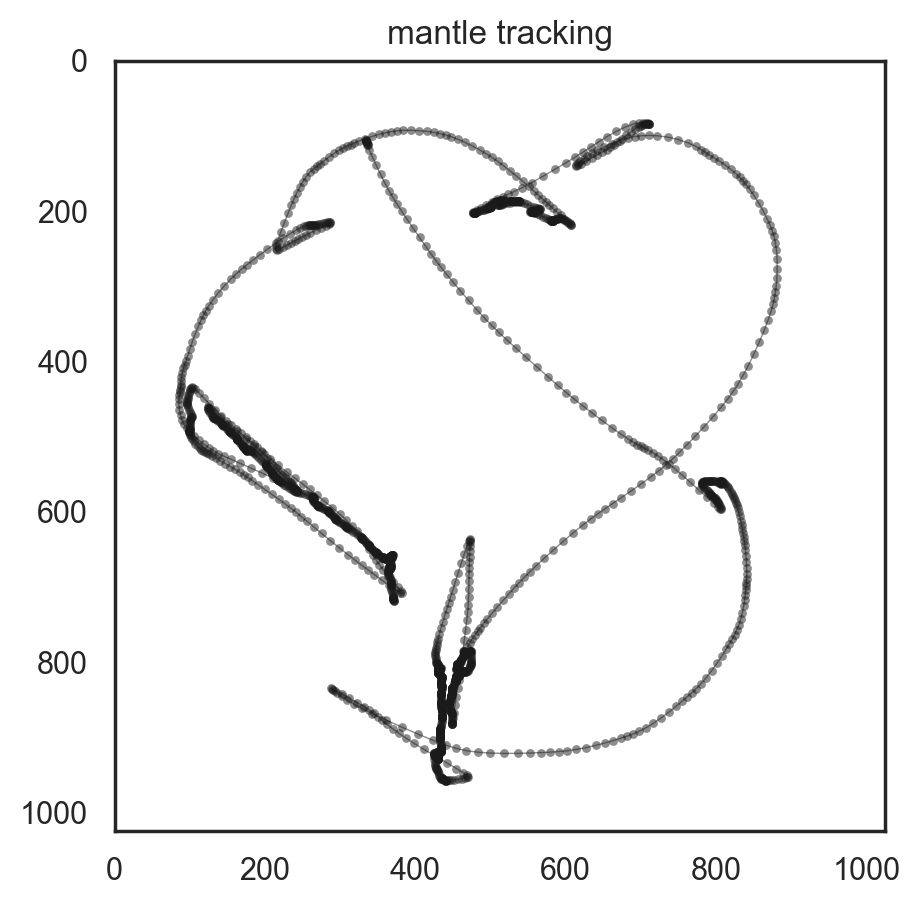

In [104]:
figure = plt.figure(figsize=(5, 5))
ax = figure.add_subplot(111)
ax.set_title(f'{data_label} tracking')
ax.scatter(tracking_example_label['pos_x'], tracking_example_label['pos_y'], c='k', s=10, alpha=0.5, lw=0)  
ax.plot(tracking_example_label['pos_x'], tracking_example_label['pos_y'], c='k', alpha=0.5, lw=0.5)
plt.axis('scaled')
ax.set_xlim(0, yolo_results.width)
ax.set_ylim(yolo_results.height, 0)

In [105]:
# Similarly, to load features for one label, use .get_features_for_label()
features_example_label = yolo_results.get_features_for_label(data_label)
features_example_label.head()

,frame_idx,confidence,area,eccentricity,orientation,solidity
0,0,0.877970,994.0,0.167298,-1.201122,0.962246
1,1,0.869778,915.0,0.225833,0.099699,0.972370
2,2,0.861851,862.0,0.342241,0.711083,0.972912
3,3,0.860288,858.0,0.309740,0.998112,0.972789
4,4,0.869096,953.0,0.331509,-0.745305,0.962626


### Mask data

In [106]:
# To load the mask data, use .get_mask_data()
# You have the option to close holes in the masks, which is useful for some applications
# CAVE: close_holes is a very expensive operation, so use it only if you really need it!
masks = yolo_results.get_mask_data(close_holes=False)
# This returns a dictionary with the track_id as key

In [107]:
# Each masks entry is a dictionary with the keys "label", "data" and "frame_indices",
# where frame_indices is a list of frame indices for which the mask is available
masks[2].keys()

dict_keys(['label', 'data', 'frame_indices'])

In [109]:
# To load masks for a specific label, there is a convenience function .get_masks_for_label()
# It returns a tuple with the masks and the frame indices
data_label = 'mantle'
masks_example_label, frame_indices = yolo_results.get_masks_for_label(data_label, close_holes=False)

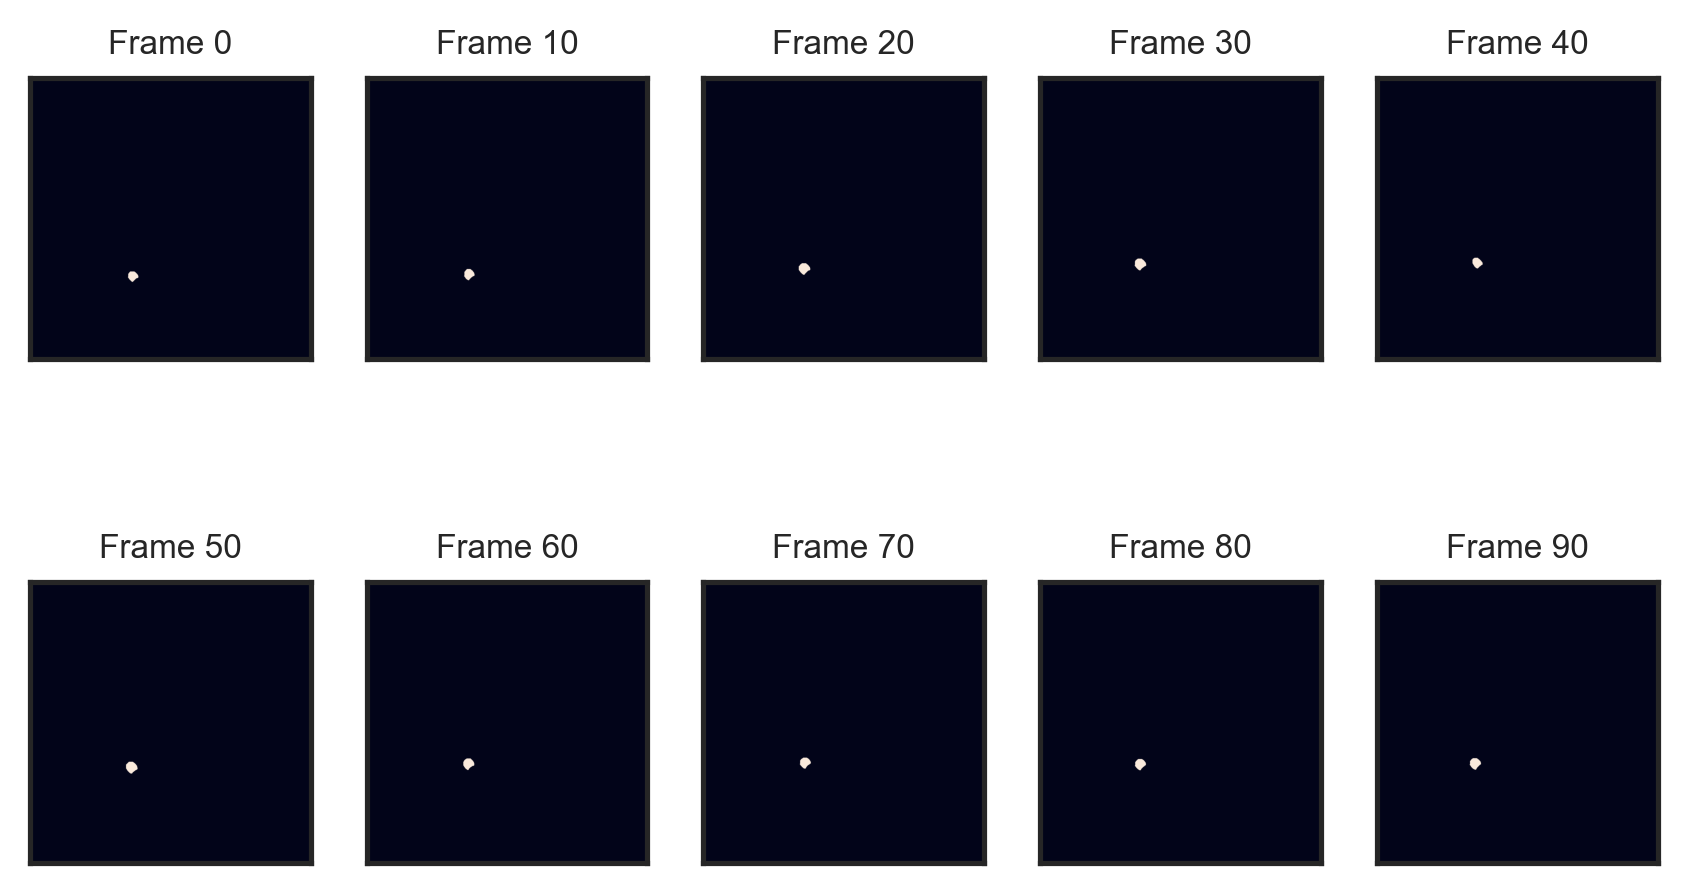

In [110]:
figure = plt.figure(figsize=(7, 4), dpi=150)
for no, index in enumerate(range(0,100,10)):
    current_index = frame_indices[index]
    ax = figure.add_subplot(2, 5, no+1) 
    ax.imshow(masks_example_label[current_index])
    ax.set_title(f'Frame {current_index}', fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [112]:
# If you want to just know which of the video frames contain data for each track_id,
# you use .get_frame_indices()
frame_indices_across_ids = yolo_results.get_frame_indices()
frame_indices_across_ids[2]

array([   0,    1,    2, ..., 1799, 1800, 1801])

### Some playful examples

#### Draw outlines ... 

In [113]:
from octron.yolo_octron.helpers.yolo_plotting import (make_linear_colormap,
                                                      get_outline
                                                      )

100%|██████████| 1776/1776 [02:56<00:00, 10.04it/s]


[]

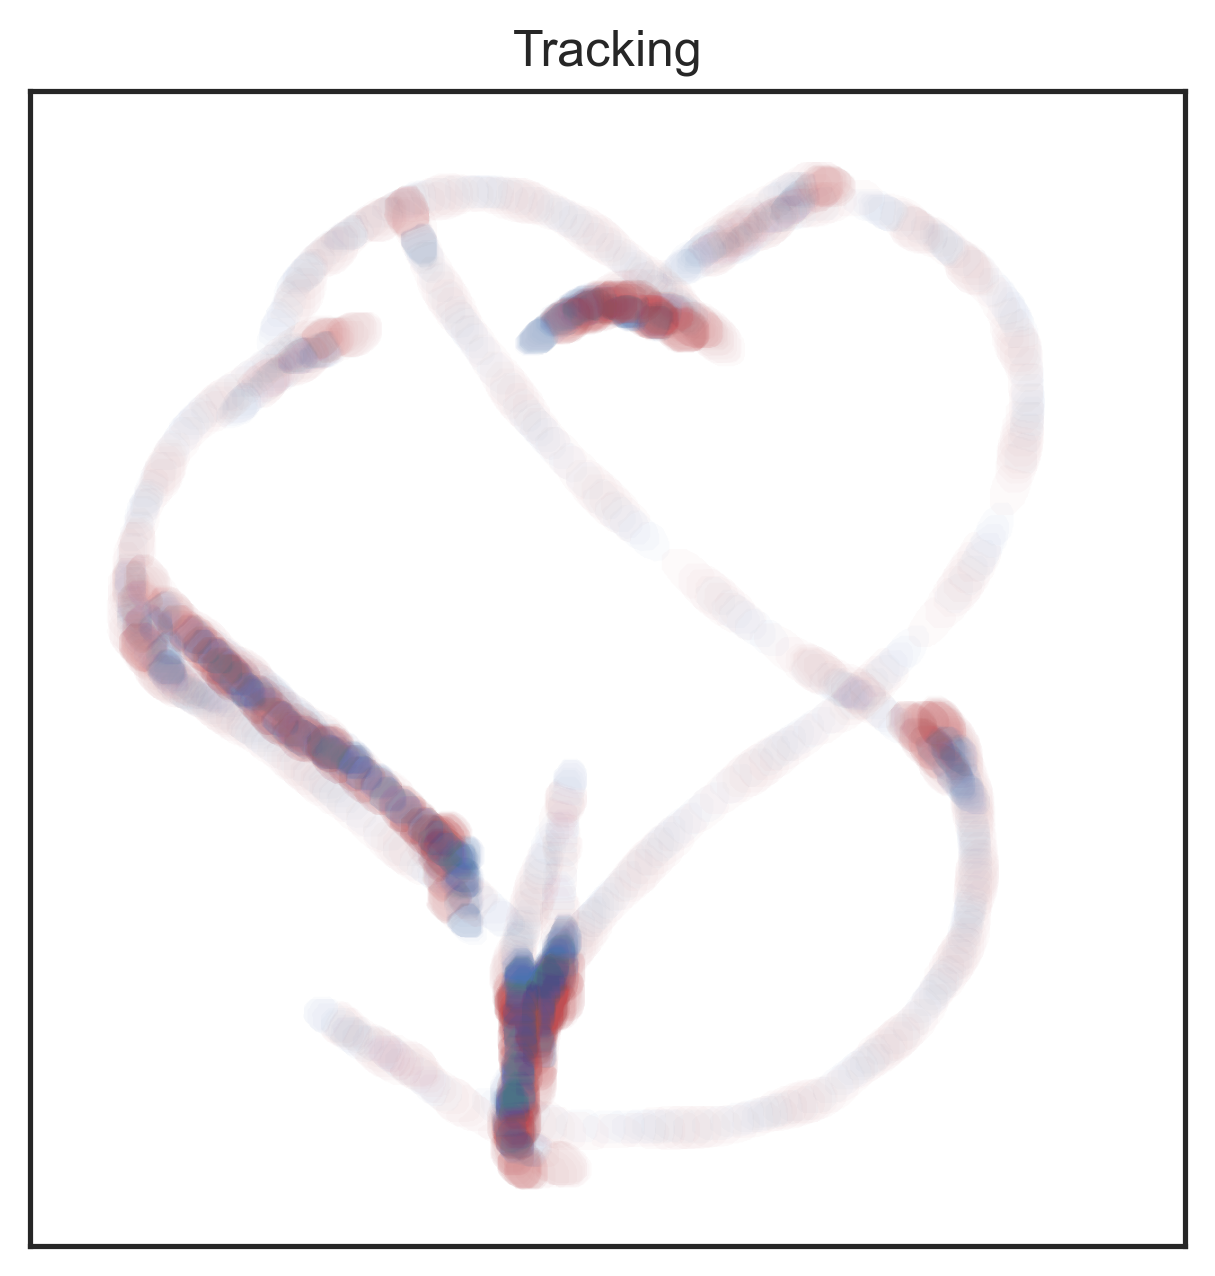

In [114]:
masks_mantle, frame_indices_masks = yolo_results.get_masks_for_label('mantle')
masks_head, _ = yolo_results.get_masks_for_label('head')

outlines_mantle = []
outlines_head = []

figure = plt.figure(figsize=(5, 5), dpi=150)
ax = figure.add_subplot(111)
ax.set_title(f'Tracking')

for frame_idx in tqdm(frame_indices_masks):
    mask_mantle = masks_mantle[frame_idx]
    mask_head = masks_head[frame_idx]
    outline_mantle = get_outline(mask_mantle)
    outline_head = get_outline(mask_head)
    outlines_mantle.append(outline_mantle)
    outlines_head.append(outline_head)

for outline_mantle, outline_head in zip(outlines_mantle, outlines_head):
    ax.plot(outline_mantle[:, 1], outline_mantle[:, 0], color='r', lw=0.5, alpha=0.025)
    ax.plot(outline_head[:, 1], outline_head[:, 0], color='b', lw=0.5, alpha=0.025) 
    
plt.axis('scaled')
ax.set_xlim(0, yolo_results.width)
ax.set_ylim(yolo_results.height, 0)
ax.set_xticks([])
ax.set_yticks([])

#### How to mask original video frames

Text(0.5, 1.0, 'Masked video frame for mantle at frame index 0')

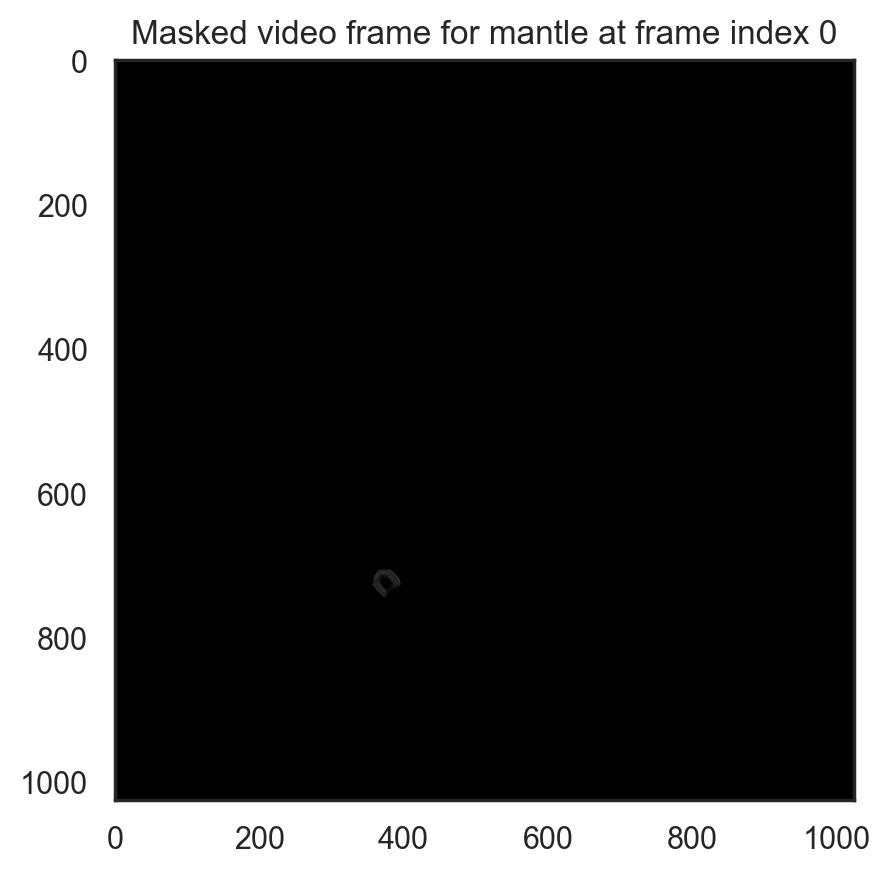

In [115]:
# Sometimes you might want to use the mask data together with the original video 
# to extract masked video frames. 
# This can then be used to use the original video data to calculate image statistics 
# for only the masked area. 

# There is a convenience function to extract the masked video frames
data_label = 'mantle'
masked_video_frames = yolo_results.get_masked_video_frames(data_label, [frame_indices[0]])
plt.imshow(masked_video_frames)
plt.title(f'Masked video frame for {data_label} at frame index {frame_indices[0]}')

### YOLO OCTRON and napari

In [116]:
# You can access the yolo_octron class directly if you want to use it for your own purposes
# This allows you to plot things in napari like you would when 
# drag-and-dropping the results into napari
# This is just a convenience function to load the results, but should not be used for 
# any serious analysis.
# In fact, YOLO_octron accesses YOLO_results to load the results.
from octron import YOLO_octron

In [119]:
results_dir = '/Users/horst/Library/CloudStorage/GoogleDrive-hobenhaus@gmail.com/My Drive/OCTRON/Project folders - finished/octo_paralarvae/test_snippets/single hatchling data/resized1024/predictions/20221203_1PL_1mM_Dop2_snippet1_1024x1024_bytetrack'
yolo_octron = YOLO_octron()

# Loop over all results and add them to napari one by one
for label, track_id, color, tracking_df, features_df, masks in yolo_octron.load_predictions(save_dir=results_dir, 
                                                                                            sigma_tracking_pos=2, 
                                                                                            open_viewer=True
                                                                                            ):
    # you can access the tracking_df and features_df here if you want to ...
    # ... 
    # ... 
    # ... or just continue 
    continue

No models YAML path provided. Model dictionary will be empty.
File: 20221203_1PL_1mM_Dop2_snippet1_1024x1024.mp4
Codec: h264
Resolution: 1024 x 1024
Frame Rate: 30.00 fps
Number of frames: 1802
Duration: 60.07 seconds
Found 2 tracking CSV files in '20221203_1PL_1mM_Dop2_snippet1_1024x1024_bytetrack'
Found tracking zarr in '20221203_1PL_1mM_Dop2_snippet1_1024x1024_bytetrack'
Existing keys in zarr archive: ['1_masks', '2_masks']
Found 2 unique track IDs in zarr and CSVs: {1: 'head', 2: 'mantle'}
Frames are not continuous for track_id 1 in head_track_1.csv... interpolating
Smoothing position data for track_id 1 with sigma=2
Frames are not continuous for track_id 2 in mantle_track_2.csv... interpolating
Smoothing position data for track_id 2 with sigma=2


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/Users/horst/miniconda3/envs/sam2/lib/python3.11/site-packages/napari_pyav/_reader.py:139: UserWarning: Seek problem with frame 1801! pts: 923648; target: 922112; dts: None; pict_type: 2
  warn_transcode(f'Seek problem with frame {frame_idx}! pts: {frame_obj.pts}; target: {target_pts}; dts: {frame_obj.dts}; pict_type: {str(frame_obj.pict_type)}')
/Users/horst/miniconda3/envs/sam2/lib/python3.11/site-packages/napari_pyav/_reader.py:139: UserWarning: Consider transcoding (ffmpeg -y -i "input.mp4" -c:v libx264 -pix_fmt yuv420p -preset superfast -crf 23 "output.mp4").
  warn_transcode(f'Seek problem with frame {frame_idx}! pts: {frame_obj.pts}; target: {target_pts}; dts: {frame_obj.dts}; pict_type: {str(frame_obj.pict_type)}')
